# 1. Build the Data Set: Dynamic Web Scrapping
We need Dynamic Web Scrapping because the result of the [IFPRI Publications Repository](https://ebrary.ifpri.org/digital/collection/p15738coll2/search/searchterm/brief/field/type/mode/all/conn/and/order/date/ad/desc) changed based on the condition and the user's interaction with the pages. We use the package [selenium](https://www.selenium.dev/selenium/docs/api/py/index.html) to conduct dynamic web scrapping.

### Retrieve Link of the brief
This step first gathers all the links to the English policy brief. Later, we will visit all the links to extract the metadata from each page.

In [1]:
### 0. Import packages 

import pandas as pd

# Dynamic Web Scrapping
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
### 1. Get the the library website with the links to each brief

# IFPRI Publication Repository, All Brief in English
search = "https://ebrary.ifpri.org/digital/collection/p15738coll2/search/searchterm/Brief!English/field/type!langua/mode/exact!exact/conn/and!and/order/date/ad/desc/page/"

In [3]:
# Function to extract the brief address 
# We will use this function for the while loop below

def find_brief_address(num):
    element = driver.find_element(By.XPATH, "/html/body/div/div/div[2]/div[1]/div/div/div[2]/div[2]/div[3]/div[2]/a["+str(num)+"]")
    return element.get_attribute("href")


In [4]:
# Start at page 1
page = 1

# Create an instance of Firefox WebDriver
driver = webdriver.Firefox()

# Empty list to save the url
list_url = []


## Get the links to each brief of interest
# The whlie loop will break whenever it reaches the end of the page. 
# It will say that it has an "error", but it is not an error if the message prints the last page number in the end.
while True:
    # Create a link for the page
    this_page = search+str(page)
    
    try:
        # Open the page
        driver.get(this_page)

        # Wait until the page is open
        try:
            element = WebDriverWait(driver, 60).until(
                # Wait until all element of the body is loaded
                EC.presence_of_all_elements_located((By.XPATH, "/html/body/div/div/div[2]/div[1]/div/div/div[2]/div[2]/div[3]/div[2]"))
            )
        except:
            print("get succeeded, but error in page "+str(page))
            driver.quit()
            break

        # Put the url into a list
        brief_list_for_page = [find_brief_address(brief_num) for brief_num in range(1,11)]

        # accumulate in a list
        list_url += brief_list_for_page
        
        # Move to the Next Page
        page += 1
    
    except: 
        print("error in page "+str(page))
        break
    

error in page 142


### Extract Individual Brief
We will use the list of the policy brief url to extract the metadata of the policy briefs.

In [5]:
### 2. Extract Meta data of the individual briefs
# Function to extract the text from the element
# We will use this function and the function below to extract the metadata for each brief as a dictionary

def extract_element_text(css_selector: str) -> str:
    element= driver.find_element(By.CSS_SELECTOR, css_selector)
    return element.text

In [6]:
def extract_brief_info(url:str) -> dict:
    '''
    Create a dictionary that includes all the attributes and the values from a single policy brief's metadata

    Parameter: 
    - url (str) : url of a single policy brief

    Return:
    - result_dict (dict): a dictionary that has the attributes as a key and the according value as a value.
    '''
    
    # Open the page
    driver.get(url)    
    
    # Wait
    try:
        element = WebDriverWait(driver, 60).until(
            # Wait until all element of the body is loaded
            EC.presence_of_all_elements_located((By.TAG_NAME, "table"))
        )
    except:
        print("error in waiting "+str(page))
        driver.quit()

    # CSS Selector for needed information
    # initial values
    i = 1
    result_dict = {} 

    while True:
        try:
            key = extract_element_text("tr.ItemMetadata-metadatarow:nth-child("+str(i)+") > td:nth-child(1)")
            value = extract_element_text("tr.ItemMetadata-metadatarow:nth-child("+str(i)+") > td:nth-child(2)")
            result_dict[key] = value
            i += 1
        except:
            break

    return result_dict


In [7]:
# Apply the extract_brief_info to each list to save the dictionary resulted by it
# list_url is the name of the list that consists all urls.
dict_list = [extract_brief_info(list_url[num]) for num in range(0, len(list_url))]


### Convert a list of Dictionary to a Dataframe
We will now convert the scrapped data to a dataframe. However, we need to be aware that not all metadata have all 52 attributes of the policy brief.

In [8]:
### 3. Convert to Dataframe

# Find all attributes and put it in a list
key = []
for dict in dict_list:
    key += dict.keys()
key = sorted(set(key))

In [9]:
# Convert to a dataframe that has the attributes as columns
df = pd.DataFrame(columns = key)

# Fill in the dataframe
for col in key:
    list = []
    for dict in dict_list:
        try:
            list.append(dict[col])
        except:
            list.append(None) 
    df[col] = list

In [10]:
# Check the dataframe
df.head()

,Abstract,Access Rights,Associated dataset,Author,CGIAR Research Program,CONTENTdm file name,CONTENTdm number,Contributors,Creative Commons CC License,DOI,...,Subject - author supplied keywords,Subject - country location,Subject - keywords,Subtitle,Table of Contents,Times cited-- Google Scholar,Title,Web link,Year,e-book link
0,Four important implications for policy to prom...,Open Access,None,"Ecker, Olivier\nComstock, Andrew R.\nPauw, Karl",None,136982.pdf,136771,None,https://creativecommons.org/licenses/by/4.0/\n...,https://doi.org/10.2499/9780896294547,...,None,KENYA\nEAST AFRICA\nAFRICA SOUTH OF SAHARA\nAF...,diet\nnutrition\nchild stunting\nfood consumpt...,None,None,https://scholar.google.com/scholar?hl=en&as_sd...,"A healthy diet is costly, but even with limite...",None,2023,Google Books http://books.google.com/books/abo...
1,The policy brief provides an overview of the u...,Open Access,https://doi.org/10.7910/DVN/XLKGGA,"Breisinger, Clemens\nMbuthia, Juneweenex\nOmun...",None,136986.pdf,136774,None,https://creativecommons.org/licenses/by/4.0/\n...,https://doi.org/10.2499/p15738coll2.136774,...,Social Accounting Matrices (SAMs),KENYA\nEAST AFRICA\nAFRICA SOUTH OF SAHARA\nAF...,family budget\npolicies\nproduction\ncommoditi...,None,None,https://scholar.google.com/scholar?hl=en&as_sd...,Updated social accounting matrices for Kenya: ...,None,2023,None
2,Tanzania experienced strong annual economic gr...,Open Access,None,"Benfica, Rui\nDiao, Xinshen\nPauw, Karl\nRandr...",None,137000.pdf,136787,None,https://creativecommons.org/licenses/by/4.0/\n...,https://doi.org/10.2499/p15738coll2.136787,...,gross domestic product (GDP),TANZANIA\nEAST AFRICA\nAFRICA SOUTH OF SAHARA\...,agrifood systems\nvalue chains\nmarkets\nagric...,None,None,https://scholar.google.com/scholar?hl=en&as_sd...,Tanzania’s agrifood system structure and drive...,None,2023,Google Books http://books.google.com/books/abo...
3,Ghana experienced rapid economic growth with a...,Open Access,None,"Pauw, Karl\nRandriamamonjy, Josee\nThurlow, Ja...",None,137013.pdf,136788,None,https://creativecommons.org/licenses/by/4.0/\n...,https://doi.org/10.2499/p15738coll2.136788,...,gross domestic product (GDP),GHANA\nWEST AFRICA\nAFRICA SOUTH OF SAHARA\nAF...,agrifood systems\nvalue chains\nmarkets\nagric...,None,None,https://scholar.google.com/scholar?hl=en&as_sd...,Ghana’s agrifood system structure and drivers ...,None,2023,Google Books http://books.google.com/books/abo...
4,Senegal experienced annual economic growth of ...,Open Access,None,"Pauw, Karl\nRandriamamonjy, Josee\nThurlow, Ja...",None,137010.pdf,136790,None,https://creativecommons.org/licenses/by/4.0/\n...,https://doi.org/10.2499/p15738coll2.136790,...,gross domestic product (GDP),SENEGAL\nWEST AFRICA\nAFRICA SOUTH OF SAHARA\n...,agrifood systems\nvalue chains\nmarkets\nagric...,None,None,https://scholar.google.com/scholar?hl=en&as_sd...,Senegal’s agrifood system structure and driver...,None,2023,Google Books http://books.google.com/books/abo...


In [11]:
# Export to csv for future reference
# I comment it out to prevent accidentally overwriting the existing data
# pd.DataFrame(df).to_csv('data/ifpri_brief_df.csv')

# 2. Data Cleaning & Exploratory Data Analysis Prior to the Text Analysis

In [1]:
### 0. Import packages
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
### 1. Read dataframe
df = pd.read_csv("data/ifpri_brief_df.csv")
df = df.drop(['Unnamed: 0'], axis= 1)

In [3]:
# Shape of the dataframe
df.shape

(1410, 52)

In [4]:
### 2. Extract Attributes of Interest
# We extract the attributes for the exploratory analysis, but the data cleaning process is included in the preprocessing.py
# There is no need to run this part of the script when you are just running the LDA

df_of_interest = df[['Title', 'Year', 'Author', 'Abstract', 'IFPRI Descriptors', 'Subject - author supplied keywords',
       'Subject - country location', 'Subject - keywords']]
df_of_interest

,Title,Year,Author,Abstract,IFPRI Descriptors,Subject - author supplied keywords,Subject - country location,Subject - keywords
0,"A healthy diet is costly, but even with limite...",2023,"Ecker, Olivier\nComstock, Andrew R.\nPauw, Karl",Four important implications for policy to prom...,2 Promoting Healthy Diets and Nutrition for al...,NaN,KENYA\nEAST AFRICA\nAFRICA SOUTH OF SAHARA\nAF...,diet\nnutrition\nchild stunting\nfood consumpt...
1,Updated social accounting matrices for Kenya: ...,2023,"Breisinger, Clemens\nMbuthia, Juneweenex\nOmun...",The policy brief provides an overview of the u...,IFPRI1\n3 Building Inclusive and Efficient Mar...,Social Accounting Matrices (SAMs),KENYA\nEAST AFRICA\nAFRICA SOUTH OF SAHARA\nAF...,family budget\npolicies\nproduction\ncommoditi...
2,Tanzania’s agrifood system structure and drive...,2023,"Benfica, Rui\nDiao, Xinshen\nPauw, Karl\nRandr...",Tanzania experienced strong annual economic gr...,IFPRI1\n4 Transforming Agricultural and Rural ...,gross domestic product (GDP),TANZANIA\nEAST AFRICA\nAFRICA SOUTH OF SAHARA\...,agrifood systems\nvalue chains\nmarkets\nagric...
3,Ghana’s agrifood system structure and drivers ...,2023,"Pauw, Karl\nRandriamamonjy, Josee\nThurlow, Ja...",Ghana experienced rapid economic growth with a...,IFPRI1\n4 Transforming Agricultural and Rural ...,gross domestic product (GDP),GHANA\nWEST AFRICA\nAFRICA SOUTH OF SAHARA\nAF...,agrifood systems\nvalue chains\nmarkets\nagric...
4,Senegal’s agrifood system structure and driver...,2023,"Pauw, Karl\nRandriamamonjy, Josee\nThurlow, Ja...",Senegal experienced annual economic growth of ...,IFPRI1\n4 Transforming Agricultural and Rural ...,gross domestic product (GDP),SENEGAL\nWEST AFRICA\nAFRICA SOUTH OF SAHARA\n...,agrifood systems\nvalue chains\nmarkets\nagric...
...,...,...,...,...,...,...,...,...
1405,Understanding how resources are allocated with...,1992,International Food Policy Research Institute (...,NaN,IFPRI1,NaN,NaN,households\neconomic aspects
1406,Technology policy for sustainable agricultural...,1990,International Food Policy Research Institute (...,NaN,IFPRI1,NaN,NaN,sustainable agriculture\ncongresses\ntechnolog...
1407,Environmental aspects of agricultural development,1990,International Food Policy Research Institute (...,NaN,IFPRI1,NaN,NaN,agricultural development\nenvironmental aspects
1408,Structural change in African agriculture,1990,International Food Policy Research Institute (...,NaN,IFPRI1,NaN,AFRICA SOUTH OF SAHARA\nAFRICA,agricultural policies\ncase studies\nstructura...


In [5]:
# Find policy briefs with/without abstract
# There is no need to run this part of the script when you are just running the LDA

df_with_abstract = df_of_interest[df_of_interest.Abstract.isnull() == False]
df_null_abstract = df_of_interest[df_of_interest.Abstract.isnull()]

In [6]:
### 3. Exploratory Analysis
# Describe the dataset with abstract
df_with_abstract.describe()

,Year
count,1084.000000
mean,2010.374539
std,7.922870
min,1994.000000
25%,2004.000000
50%,2009.000000
75%,2019.000000
max,2023.000000


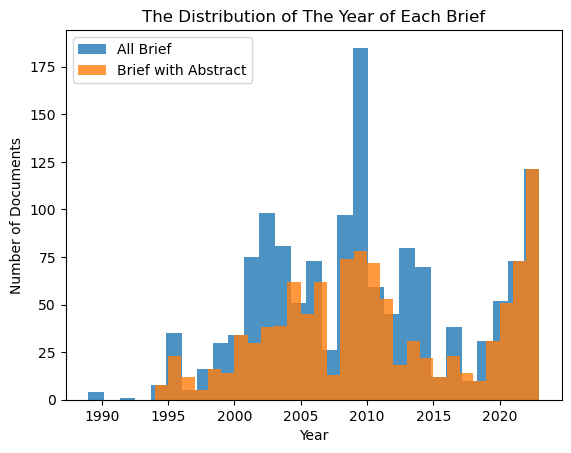

In [7]:
# Histogram comparing the years of the abstract that has/does not have an abstract

plt.hist(df.Year, bins = 29, alpha = 0.8, label = "All Brief")
plt.hist(df_with_abstract.Year, bins = 29, alpha = 0.8, label = "Brief with Abstract")
plt.title("The Distribution of The Year of Each Brief")
plt.xlabel("Year")
plt.ylabel("Number of Documents")
plt.legend(loc = 'upper left')
plt.show()